In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from src.model import LeNet5
from src.exp import run_experiment, run_experiment_all_optimizers
from torch.optim import LBFGS, Adam

from optim_adahessian import Adahessian
from apollo import Apollo

import src.utils as utils

import matplotlib.pyplot as plt
import logging

from pyhessian import hessian

import pickle
import copy
import numpy as np

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format="%(message)s")

%load_ext autoreload
%autoreload 2
%load_ext nb_black

Generating grammar tables from /home/.local/lib/python3.8/site-packages/blib2to3/Grammar.txt
Writing grammar tables to /home/.cache/black/21.6b0/Grammar3.8.8.final.0.pickle
Writing failed: [Errno 2] No such file or directory: '/home/.cache/black/21.6b0/tmpv31kcyqr'
Generating grammar tables from /home/.local/lib/python3.8/site-packages/blib2to3/PatternGrammar.txt
Writing grammar tables to /home/.cache/black/21.6b0/PatternGrammar3.8.8.final.0.pickle
Writing failed: [Errno 2] No such file or directory: '/home/.cache/black/21.6b0/tmpikzdoue7'


<IPython.core.display.Javascript object>

In [8]:
def perturbate_model_2d(model, model_per, direction_1, direction_2, alpha_1, alpha_2):

    for param_p, param_o, d_1, d_2 in zip(
        model_per.parameters(), model.parameters(), direction_1, direction_2
    ):
        with torch.no_grad():
            param_p.data = param_o.data + d_1 * alpha_1 + d_2 * alpha_2

    return model_per


def perturbate_model(model, model_per, direction, alpha):

    for param_p, param_o, d in zip(
        model_per.parameters(), model.parameters(), direction
    ):
        with torch.no_grad():
            param_p.data = param_o.data + d * alpha

    return model_per

<IPython.core.display.Javascript object>

In [75]:
def compute_minimum_shape(
    model, dataset_name, max_amp_pert=0.5, num_per=25, batch_size=2000, use_3d=False
):
    # Work with only one (big) batch
    train_loader, _ = utils.load_data(
        "/home/app/datasets", batch_size=batch_size, dataset="MNIST"
    )
    inputs, targets = next(iter(train_loader))

    criterion = torch.nn.CrossEntropyLoss()

    model_hessian = hessian(model, criterion, data=(inputs, targets), cuda=False)
    top_n = 2 if use_3d else 1
    top_eigenvalues, top_eigenvectors = model_hessian.eigenvalues(top_n=top_n)
    density_eigen, density_weight = model_hessian.density()

    alphas = np.linspace(-max_amp_pert, max_amp_pert, num_per).astype(np.float32)
    losses = []
    model_per = copy.deepcopy(model)

    for alpha in alphas:
        if use_3d:
            for alpha_2 in alphas:
                model_per = perturbate_model_2d(
                    model,
                    model_per,
                    top_eigenvectors[0],
                    top_eigenvectors[1],
                    alpha,
                    alpha_2,
                )
                losses.append(criterion(model_per(inputs), targets).item())
        else:
            model_per = perturbate_model(model, model_per, top_eigenvectors[0], alpha)
            losses.append(criterion(model_per(inputs), targets).item())

    return alphas, losses, density_eigen, density_weight

<IPython.core.display.Javascript object>

In [76]:
results = pickle.load(open("MNIST_results.dic", "rb"))

<IPython.core.display.Javascript object>

In [77]:
model = results["MNIST"]["AdaHessian"]["model"]

<IPython.core.display.Javascript object>

In [78]:
alphas, losses, density_eigen, density_weight = compute_minimum_shape(model, "MNIST")

<IPython.core.display.Javascript object>

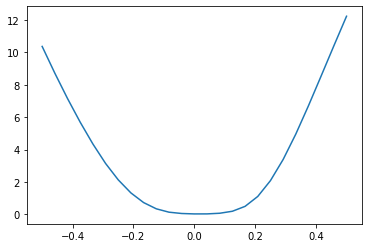

<IPython.core.display.Javascript object>

In [74]:
plt.plot(alphas, losses)

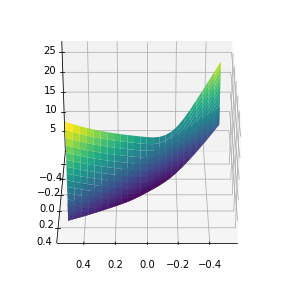

<IPython.core.display.Javascript object>

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=30, azim=90)
ax.plot_surface(X=alphas, Y=alphas, Z=losses, cmap="viridis")
fig.show()